# Reflections Notebook, Weeks 5 - 8

In [35]:
import pandas as pd
import numpy as np
from graphviz import Digraph
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

## Homework Reflection 5

### 1. Draw a diagram for the following negative feedback loop:
- Sweating causes body temperature to decrease.  High body temperature causes sweating.
- A negative feedback loop means that one thing increases another while the second thing decreases the first.
- Remember that we are using directed acyclic graphs where two things cannot directly cause each other.

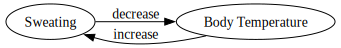

In [6]:
from graphviz import Digraph

dot = Digraph(graph_attr={'rankdir':'LR'})
dot.node('S', 'Sweating')
dot.node('T', 'Body Temperature')
dot.edge('S', 'T', label='decrease')
dot.edge('T', 'S', label='increase')
dot

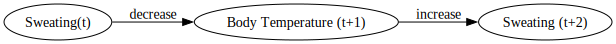

In [9]:

# Create a left→right layout
dot = Digraph(graph_attr={'rankdir': 'LR'})

# Define the time-indexed nodes
dot.node('S_t',  'Sweating(t)')
dot.node('T_t1', 'Body Temperature (t+1)')
dot.node('S_t2', 'Sweating (t+2)')
dot.edge('S_t',  'T_t1', label='decrease')
dot.edge('T_t1','S_t2', label='increase')
dot

### 2. Describe an example of a positive feedback loop.  (This means that one things increases another while the second things also increases the first.)

The process of ripening transforms immature, hard, and inedible fruits into the ripe and delicious fruits that we (and other organisms) enjoy. Ripening is regulated by the hormone ethylene.
When fruits begin to ripen, they release a small amount of gaseous ethylene. As ripening continues, the fruits release more ethylene, which promotes ripening even further. Eventually, the ripening process is driven to completion.

The fact that ethylene is released as a gas means that other fruits nearby are also induced to ripen. This is why if you have unripe fruits such as bananas, tomatoes, or avocados, you can put them together in a bag. The build-up of ethylene inside the bag will cause the fruits to ripen more quickly! 

https://www.khanacademy.org/science/hs-bio/x230b3ff252126bb6:from-cells-to-organisms/x230b3ff252126bb6:homeostasis/a/positive-feedback-loop-examples

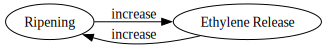

In [ ]:
from graphviz import Digraph
# set digraph orientation to left-to-right
dot = Digraph(graph_attr={'rankdir':'LR'})
# set nodes
dot.node('R', 'Ripening')
dot.node('E', 'Ethylene Release')
# add edges
dot.edge('R', 'E', label='increase')
dot.edge('E', 'R', label='increase')

dot

### 3a. Draw a diagram for the following situation:
- Lightning storms frighten away deer and bears, decreasing their population, and cause flowers to grow, increasing their population.
- Bears eat deer, decreasing their population.
- Deer eat flowers, decreasing their population.

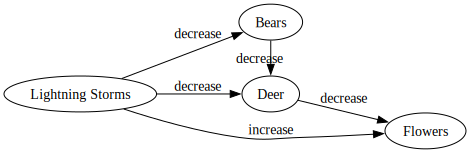

In [17]:
dot = Digraph(graph_attr={'rankdir':'LR'})

# 1. Define nodes
dot.node('L', 'Lightning Storms')
dot.node('D', 'Deer')
dot.node('B', 'Bears')
dot.node('F', 'Flowers')

# 2. Group Deer & Bears on the same rank
with dot.subgraph() as s:
    s.attr(rank='same')
    s.node('D')
    s.node('B')

# 3. Add edges
dot.edge('L', 'D', label='decrease')
dot.edge('L', 'B', label='decrease')
dot.edge('L', 'F', label='increase')
dot.edge('B', 'D', label='decrease')
dot.edge('D', 'F', label='decrease')

dot


### 3b. Write a dataset that simulates this situation.  (Show the code.) Include noise / randomness in all cases.

In [22]:

np.random.seed(42)
n = 10000

# lightning occurs (0/1)
L = np.random.binomial(1, 0.1, size=n)

# Independent noise for each variable
noise_B = np.random.normal(0, 1, size=n)
noise_D = np.random.normal(0, 1, size=n)
noise_F = np.random.normal(0, 1, size=n)

# 3) Baseline population sizes
baseline_B = 5
baseline_D = 20
baseline_F = 50

# Bears respond only to lightning + noise
B = baseline_B - 3.0 * L + noise_B
# Deer respond to lightning, bears, + noise
D = baseline_D - 2.0 * L - 0.5 * B + noise_D
# Flowers respond to lightning, deer, + noise
F = baseline_F + 4.0 * L - 0.3 * D + noise_F

# Package into a DataFrame
df = pd.DataFrame({
    'Lightning': L,
    'Bears':      B,
    'Deer':       D,
    'Flowers':    F,
})

df.head()

,Lightning,Bears,Deer,Flowers
0,0,3.512138,17.627783,45.495347
1,1,0.874814,17.169918,48.856563
2,0,5.388819,16.273764,45.772684
3,0,3.826127,17.197685,43.826378
4,0,6.112634,17.378060,44.929968


A few notes on the numbers:
- -3.0 and -2.0 are just example “effect sizes” for how strongly a lightning storm suppresses bears versus deer;
- -0.5 * B encodes “bears eat deer,” and
- -0.3 * D encodes “deer eat flowers.”

Because each noise term is independent (noise_B, noise_D, noise_F), the only correlations come from your causal structure.

### 3c. Identify a backdoor path with one or more confounders for the relationship between deer and flowers.

One potential back-door path from Deer to Flowers is:
$$\text{Deer} \leftarrow \text{Lightning Storms} \rightarrow \text{Flowers}$$

Because $\text{Lightning Storms}$ both: 
- Frighten away $\text{Deer}$ (decreasing $D$)
- Cause $\text{flowers}$ to grow (increasing $F$) 

it is a confounder of both $D$ and $F$. 

To block that non-causal path you’d need to adjust for (i.e. condition on) $\text{Lightning storms}$.

### 4a Draw a diagram for a situation of your own invention.
- The diagram should include at least four nodes, one confounder, and one collider.  
- Be sure that it is acyclic (no loops).

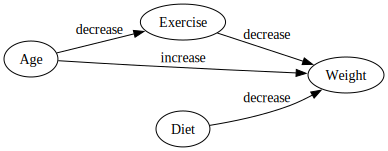

In [25]:
dot = Digraph(graph_attr={'rankdir':'LR'})

# Nodes
dot.node('A', 'Age')
dot.node('E', 'Exercise')
dot.node('D', 'Diet')
dot.node('W', 'Weight')

# Align Exercise & Diet at the same “level” so they converge nicely on Weight
with dot.subgraph() as s:
    s.attr(rank='same')
    s.node('E')
    s.node('D')

# Edges (effects labeled as increase/decrease)
# Age to Exercise (confounder path)
dot.edge('A', 'E', label='decrease')
# Age to Weight (confounder path)
dot.edge('A', 'W', label='increase')

# Exercise to Weight to Diet (Weight is a collider)
dot.edge('E', 'W', label='decrease')
dot.edge('D', 'W', label='decrease')

dot

**Confounder:** Age has arrows into both Exercise and Weight, creating the back-door path.

**Collider:** Weight sits at the intersection Exercise $\leftarrow$ Weight $\leftarrow$ Diet, so conditioning on Weight would open the non-causal path between Exercise and Diet.


### 4b. Which node would say is most like a treatment (X)?  Which is most like an outcome (Y)?
- $\text{Exercise}$ is the treatment $X$. 
- $\text{Weight}$ is the outcome $Y$.

## Homework Reflection 6

### 1. What is a potential problem with computing the Marginal Treatment Effect simply by comparing each untreated item to its counterfactual and taking the maximum difference?  

(Hint: think of statistics here.  Consider that only the most extreme item ends up being used to estimate the MTE.  That's not necessarily a bad thing; the MTE is supposed to come from the untreated item that will produce the maximum effect.  But there is nevertheless a problem.)

Possible answer: We are likely to find the item with the most extreme difference, which may be high simply due to randomness.
(Please explain / justify this answer, or give a different one if you can think of one.)

You’re almost guaranteed to pick out whichever untreated unit happened to show the largest difference. That creates two linked problems:
1. Extreme‐value (selection) bias: The maximum of a set of noisy estimates is a biased estimator of the true maximum.  If each untreated item’s difference $Y_i(1)\!-\!Y_i(0)$ has some random error, the one with the largest observed difference will tend to overstate its true effect.
2. High sampling variability: Because your MTE comes from just a single data point, it will jump around wildly from one sample to the next. An estimate that depends entirely on one outlier is inherently unstable.

### 2. Propose a solution that remedies this problem and write some code that implements your solution.  It's very important here that you clearly explain what your solution will do.
Possible answer: maybe we could take the 90th percentile of the treatment effect and use it as a proxy for the Marginal Treatment Effect. (Either code this answer or choose a different one.)

In [ ]:
# 1) Create sample data
np.random.seed(42)
df = pd.DataFrame({
    'Y0': np.random.normal(loc=0, scale=1, size=1000),   # control outcomes
    'Y1': np.random.normal(loc=1, scale=1, size=1000),   # treatment outcomes
})

# 2) Compute individual treatment effects
df['TE'] = df['Y1'] - df['Y0']

# 3) Estimate the 90th-percentile proxy for the Marginal Treatment Effect
mte_proxy_90 = np.percentile(df['TE'], 90)

print(f"90th‐percentile proxy for MTE: {mte_proxy_90:.3f}")

90th‐percentile proxy for MTE: 2.948


This will generate a DataFrame of 1,000 paired control/treatment outcomes, compute each unit’s treatment effect (TE), and then take the 90th percentile of those effects as a stable proxy for the true MTE.

## Homework Reflection 7

### 1. Create a linear regression model involving a confounder that is left out of the model.  
- Show whether the true correlation between $X$ and $Y$ is overestimated, underestimated, or neither.  
- Explain in words why this is the case for the given coefficients you have chosen.

In [36]:
n = 10000

# true coefficients
a = 1 # effect of Z on X
b = 2 # true effect of X on Y
c = 3 # effect of Z on Y

# generate data
Z = np.random.normal(0, 1, n)  # confounder
X = a * Z + np.random.normal(scale=1.0, size=n) # X influenced by Z (plus noise)
Y = b * X + c * Z + np.random.normal(scale=1.0, size=n) # Y influenced by X and Z (plus noise)

# create DataFrame
df = pd.DataFrame({'Z': Z, 'X': X, 'Y': Y})

# fit linear regression model
model_naive = LinearRegression().fit(X.reshape(-1, 1), Y)
coef_naive = model_naive.coef_[0]

# fit adjusted linear regression model
model_adj = LinearRegression().fit(df[['X', 'Z']], Y)
coef_adj = model_adj.coef_[0]

# compute correlation betwen X and Y
corr_XY = np.corrcoef(X, Y)[0, 1]

print(f"True coefficient of X (b): {b}")
print(f"Naive estimate (omit Z): {coef_naive:.2f}")
print(f"Adjusted estimate (include Z): {coef_adj:.2f}")
print(f"Sample correlation between X and Y: {corr_XY:.2f}")

True coefficient of X (b): 2
Naive estimate (omit Z): 3.51
Adjusted estimate (include Z): 1.99
Sample correlation between X and Y: 0.90


In this simulated dataset:
- The true causal effect of X on Y is b = 2.0.
- When you omit the confounder Z, the regression of Y on X alone returns a naive estimate of about 3.51, which is biased upward (overestimates the true effect).
- When you adjust for Z by fitting Y\sim X + Z, you recover the correct coefficient of 2.00.
- The simple correlation between X and Y in the full data is 0.90, reflecting the confounding influence of Z.

Why overestimation?
- Because Z positively influences both X and Y (a>0 and c>0), omitting Z induces an omitted-variable bias of $c \times \frac{\mathrm{Cov}(Z,X)}{\mathrm{Var}(X)}$.  Numerically that bias pushes the naive slope from 2.0 up to roughly 3.5.

In practice this shows that leaving out a confounder that is positively related to both the predictor and the outcome leads to an overestimate of the predictor’s effect. ￼

### 2a. Perform a linear regression analysis in which one of the coefficients is zero, e.g.

W = [`noise`]

X = [`noise`]

Y = 2 * X + [`noise`]

In [40]:
# create dataset with noise and a linear relationship
n = 10000
W = np.random.normal(0, 1, n)  # noise
X = np.random.normal(0, 1, n)  # noise
Y = 2 * X + np.random.normal(0, 1, n)
df = pd.DataFrame({'W': W, 'X': X, 'Y': Y})

model = sm.OLS(df['Y'], sm.add_constant(df[['W', 'X']]))
results = model.fit()

# calculate the p-value for the coefficient of W
p_value_W = results.pvalues['W']
print(f"P-value for coefficient of W: {p_value_W:.4f}")

P-value for coefficient of W: 0.9034


### 2b. compute the p-value of a coefficient - in this case, the coefficient of W.  

In [41]:
# calculate the p-value for the coefficient of W
p_value_W = results.pvalues['W']
print(f"P-value for coefficient of W: {p_value_W:.4f}")

P-value for coefficient of W: 0.9034


### 2c. Run the analysis 1000 times and report the best (smallest) p-value. 

In [42]:
# Run the analysis 1000 times and report the best (smallest) p-value
trials = 1000
best_p_value = float('inf')
for _ in range(trials):
    W = np.random.normal(0, 1, n)  # noise
    X = np.random.normal(0, 1, n)  # noise
    Y = 2 * X + np.random.normal(0, 1, n)
    
    df = pd.DataFrame({'W': W, 'X': X, 'Y': Y})
    model = sm.OLS(df['Y'], sm.add_constant(df[['W', 'X']]))
    results = model.fit()
    
    p_value_W = results.pvalues['W']
    if p_value_W < best_p_value:
        best_p_value = p_value_W
print(f"Best (smallest) p-value after {trials} trials: {best_p_value:.4f}")

Best (smallest) p-value after 1000 trials: 0.0031


### 2d. If the p-value is less than 0.05, does this mean the coefficient actually is nonzero?  What is the problem with repeating the analysis?

The problem with repeating the analysis and taking the best value is that we are actively p-hacking, or repeatedly attempting to fit the data over and over again until we arrive at a p-value that supports our hypothesis. 

## Homework Reflection 8

### Include the code you used to solve the two coding quiz problems and write about the obstacles / challenges / insights you encountered while solving them.